# data prepration

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from sympy.physics.units import amount
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

In [74]:
# LOAD
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


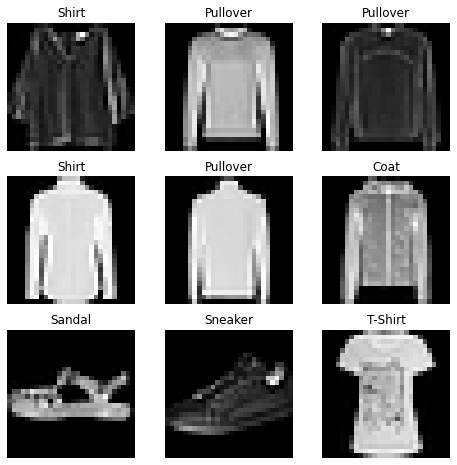

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# training

In [10]:
# model
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        #self.relu = nn.ReLU(),
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        #self.relu = nn.ReLU(),
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128 * 3 * 3, 1000)  # Adjust for output size after pooling
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(1000, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(self.bn1(torch.relu(self.conv1(x))))
        x = self.dropout(x)

        x = self.pool(self.bn2(torch.relu(self.conv2(x))))
        x = self.dropout(x)

        x = self.pool(self.bn3(torch.relu(self.conv3(x))))
        x = self.dropout(x)

        x = x.view(-1, 128 * 3 * 3)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [75]:
model = FashionMNISTModel()
print(model)

FashionMNISTModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1152, out_features=1000, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=1000, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [110]:
#train
model = FashionMNISTModel()
criterion = nn.CrossEntropyLoss() # loss function 
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9) # optimizer

#defining training hyperparameters and cuda setting 
num_epochs = 40
device = torch.device("cuda")
model.to(device)
for epoch in range(num_epochs):
    running_loss = 0.0
    for i,data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs) #passing forward the inputs
        loss = criterion(outputs, labels) # calculating loss function 
        loss.backward() # Backpropagation the loss
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:
            print(f"[Epoch {epoch + 1}, Mini-batch {i + 1}] Loss: {running_loss / 200:.3f}")
            running_loss = 0.0

torch.save(model.state_dict(), "fashion_mnist_cnn40.pth")
print("training finished and saved")


[Epoch 1, Mini-batch 200] Loss: 1.179
[Epoch 1, Mini-batch 400] Loss: 0.703
[Epoch 1, Mini-batch 600] Loss: 0.615
[Epoch 1, Mini-batch 800] Loss: 0.533
[Epoch 2, Mini-batch 200] Loss: 0.521
[Epoch 2, Mini-batch 400] Loss: 0.505
[Epoch 2, Mini-batch 600] Loss: 0.481
[Epoch 2, Mini-batch 800] Loss: 0.483
[Epoch 3, Mini-batch 200] Loss: 0.454
[Epoch 3, Mini-batch 400] Loss: 0.464
[Epoch 3, Mini-batch 600] Loss: 0.439
[Epoch 3, Mini-batch 800] Loss: 0.457
[Epoch 4, Mini-batch 200] Loss: 0.449
[Epoch 4, Mini-batch 400] Loss: 0.467
[Epoch 4, Mini-batch 600] Loss: 0.442
[Epoch 4, Mini-batch 800] Loss: 0.437
[Epoch 5, Mini-batch 200] Loss: 0.437
[Epoch 5, Mini-batch 400] Loss: 0.451
[Epoch 5, Mini-batch 600] Loss: 0.431
[Epoch 5, Mini-batch 800] Loss: 0.441
[Epoch 6, Mini-batch 200] Loss: 0.425
[Epoch 6, Mini-batch 400] Loss: 0.424
[Epoch 6, Mini-batch 600] Loss: 0.436
[Epoch 6, Mini-batch 800] Loss: 0.416
[Epoch 7, Mini-batch 200] Loss: 0.414
[Epoch 7, Mini-batch 400] Loss: 0.423
[Epoch 7, Mi

# reload the model ( for debug)


In [108]:
model = FashionMNISTModel()
model.load_state_dict(torch.load("/home/oem/Desktop/uni/ut/fashion_mnist_cnn.pth"))
device = torch.device("cuda")
model.to(device) 

FashionMNISTModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1152, out_features=1000, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=1000, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [109]:
# Test


model.eval()  


correct = 0
total = 0
with torch.no_grad():  # Disable gradient calculation during testing
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device) 
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy test images: {100 * correct / total:.2f}%")

with torch.no_grad():  # Disable gradient calculation during testing
    for data in train_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device) 
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy train images: {100 * correct / total:.2f}%")
# Class-wise accuracy (optional)


Accuracy test images: 93.14%
Accuracy train images: 96.42%


In [ ]:
# Save
torch.save(model.state_dict(), '/home/oem/Desktop/uni/ut/acc92.2200pruned0.40.pth')

#  reporting based on sklearn


In [13]:
from sklearn.metrics import classification_report
import torch
import numpy as np

all_predictions = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to NumPy
        all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to NumPy

# Generate classification report
report = classification_report(all_labels, all_predictions, target_names=labels_map.values())
print(report)


              precision    recall  f1-score   support

     T-Shirt       0.89      0.88      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.88      0.92      0.90      1000
       Dress       0.93      0.94      0.94      1000
        Coat       0.90      0.87      0.89      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.80      0.79      0.79      1000
     Sneaker       0.95      0.99      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle Boot       0.99      0.97      0.98      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



# گزارش نتیجه بدست آمده از بخش آموزش و تست 
 ضریب recall بیانگرنسبت tp به مجموع tp و fn است که نشان دهنده حساسیت مدل روی هر دسته از داده هایی است که موجود داریم 
ضریب precision بیانگر نسبت tp  به مجموع tp به fp است که بیانگر دقت تشخیص درست مدل ما از بین نمونه هایی که به عنوان هدف درست انتخاب شده اند , است . 
ضریب f1-score بیانگر میانگین بین ضرایب recall و precision است .  این ضریب دید کلی و مناسبی از دقت و کارایی مدل به ما میدهد . 
در این گزارش هر سه پارامتر به ازای هر کلاس از دیتاست بررسی شده و گزارش گردیده است .
با بررسی نتایج بدست آمده از این گزارش به این نتیجه میرسیم که  با علم بر این که دقت کلی مدل برابر با ۹۴ درصد است, در اکثر کلاس ها مقدار f1-score بالای ۹۰ درصد بوده و تفاوت اندکی با دقت کلی مدل دارد اما در بعضی از کلاس ها مانند T-Shirt  و  Shirt این نسبت کمتر از ۹۰ است و به بررسی دلیل مسئله میپردازیم .
بررسی نتیجه ضرایب Shirt : 
مقدار ضریب recall این دسته از داده ها با precision  آن برابر بوده (۰.۸۲) و این نشان دهنده آن است که مدل در این دسته بندی در تعادلی از خطا در مقادیر fp و fn  در امر شناسایی این دسته از داده است 

بررسی نتیجه ضرایب T_shirt :
دسته T_shirt دارای precisionبرابر با  0.90 ومقدار  0.88 به عنوان recallاست . این ضرایب نشان دهنده FN کمی بیشتر از FP است. این نشان می‌دهد که مدل در شناسایی درست T_shirt های واقعی در هنگام پیش‌بینی آن‌ها دقت لازم را دارد، اما بخش کمی بزرگ‌تر از T_shirt واقعی را در مجموعه داده‌ها از دست می‌دهد. 


# L1 unstructured pruning

In [19]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

## one-shot

In [20]:
# Function to apply L1 unstructured pruning
def apply_pruning(model, amount):
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prune.l1_unstructured(module, name='weight', amount=amount)

    return model



In [61]:
# reloading the model (tmp)
model = FashionMNISTModel()
model.load_state_dict(torch.load("fashion_mnist_cnn.pth"))
device = torch.device("cuda")
model.to(device) 
#print(model)
model.eval()  
# testing model
correct = 0
total = 0
with torch.no_grad():  # Disable gradient calculation during testing
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device) 
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy test images: {100 * correct / total:.2f}%")

Accuracy test images: 93.15%


In [ ]:
# To check sparsity level in layers (tmp)
model = apply_pruning(model, 0.35)

# one-step pruning

In [102]:
# one-step pruning

max_acc = 92.15
fix_mount = 0
least_it = 10
for  it in range(10,101,5):
    it = it/100
    print('checking amount= ',it)
    # pruning iteration 
    model = apply_pruning(model, it)
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation during testing
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) 
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy test images: {100 * correct / total:.2f}%\n")
    acc = 100 * correct / total
    if acc > 92.15:
        if acc > max_acc:
            max_acc = acc
            fix_mount = it
    if acc < 92 :
        print(f"the mount = {it:.2f} was exceeding the 1% accuracy loss threshold ")
        break
    # reloading the model
    model = FashionMNISTModel()
    model.load_state_dict(torch.load("fashion_mnist_cnn.pth"))
    model.to(device)



    
    

checking amount=  0.1
Accuracy test images: 93.17%

checking amount=  0.15
Accuracy test images: 92.94%

checking amount=  0.2
Accuracy test images: 93.07%

checking amount=  0.25
Accuracy test images: 92.83%

checking amount=  0.3
Accuracy test images: 92.69%

checking amount=  0.35
Accuracy test images: 91.33%

the mount = 0.35 was exceeding the 1% accuracy loss threshold 


# step by step pruning

In [104]:
# check sparsity 
def check_sparsity(model):

    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear, nn.Conv2d)):  # Check for layers with weights
            weight = module.weight.data
            zero_count = torch.sum(weight == 0)
            total_count = torch.numel(weight)  # Total number of elements in the weight tensor
            sparsity = 100. * zero_count / total_count
            print(f"Sparsity in {name}.weight: {sparsity:.2f}%")


In [111]:
#prun & finetune the pruned model
best_accuracy = 0.9314  # Original accuracy
accuracy_threshold = 0.01 # Acceptable accuracy loss
prune_amount = 0.1
prune_step = 0.05
best_prune_amount = 0

def train_and_evaluate(model, train_loader, test_loader, device, labels_map ,prune_amount):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # You might need to adjust these
    epochs = 50 # Adjust as needed
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0



    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total

    print(f"Accuracy of the network on test images after Pruning: {accuracy:.4f}%")
    torch.save(model.state_dict(), f"./pruned_results/acc{accuracy:.4f}pruned{prune_amount:.2f}.pth")
    check_sparsity(model)

    return accuracy/100

while True:
    print(f"\nPruning with amount: {prune_amount:.2f}")

    pruned_model = apply_pruning(model, prune_amount)  # Create a copy if you need the original model
    pruned_model.to(device)
    current_accuracy = train_and_evaluate(pruned_model,train_loader,test_loader,device,labels_map,prune_amount)

    if (best_accuracy - current_accuracy) < accuracy_threshold:
        best_prune_amount = prune_amount
        prune_amount += prune_step
        model = pruned_model.cpu().to(device) # update the model for the next iteration with pruning
    else:
        print(f"Accuracy dropped below threshold. Best prune amount: {best_prune_amount}")
        break




print(f"Best prune amount found: {best_prune_amount} with acceptable accuracy loss.")



Pruning with amount: 0.10
Accuracy of the network on test images after Pruning: 93.5400%
Sparsity in conv1.weight: 19.10%
Sparsity in conv2.weight: 19.00%
Sparsity in conv3.weight: 19.00%
Sparsity in fc1.weight: 19.00%
Sparsity in fc2.weight: 19.00%
Sparsity in fc3.weight: 19.00%

Pruning with amount: 0.15
Accuracy of the network on test images after Pruning: 93.4800%
Sparsity in conv1.weight: 31.25%
Sparsity in conv2.weight: 31.15%
Sparsity in conv3.weight: 31.15%
Sparsity in fc1.weight: 31.15%
Sparsity in fc2.weight: 31.15%
Sparsity in fc3.weight: 31.17%

Pruning with amount: 0.20
Accuracy of the network on test images after Pruning: 93.2500%
Sparsity in conv1.weight: 45.14%
Sparsity in conv2.weight: 44.92%
Sparsity in conv3.weight: 44.92%
Sparsity in fc1.weight: 44.92%
Sparsity in fc2.weight: 44.92%
Sparsity in fc3.weight: 44.92%

Pruning with amount: 0.25
Accuracy of the network on test images after Pruning: 92.8500%
Sparsity in conv1.weight: 59.03%
Sparsity in conv2.weight: 58.69

KeyboardInterrupt: 

FashionMNISTModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1152, out_features=1000, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=1000, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [145]:
check_sparsity(model)


Sparsity in conv1.weight: 35.07%
Sparsity in conv2.weight: 35.00%
Sparsity in conv3.weight: 35.00%
Sparsity in fc1.weight: 35.00%
Sparsity in fc2.weight: 35.00%
Sparsity in fc3.weight: 35.00%


# quantization  utils

In [ ]:
# tmp test 
import torch

def linear_quantize(input, scale, zero_point, inplace=False):
    """
    Quantize single-precision input tensor to integers with the given scaling factor and zeropoint.
    input: single-precision input tensor to be quantized
    scale: scaling factor for quantization
    zero_point: shift for quantization
    """

    # reshape scale and zero_point for convolutional weights and activations
    if len(input.shape) == 4:
        scale = scale.view(-1, 1, 1, 1)
        zero_point = zero_point.view(-1, 1, 1, 1)
    # reshape scale and zero_point for linear weights
    elif len(input.shape) == 2:
        scale = scale.view(-1, 1)
        zero_point = zero_point.view(-1, 1)

    # mapping single-precision input to integer values with the given scale and zero_point
    if inplace:
        input.mul_(scale).sub_(zero_point).round_()  # In-place quantization: input * scale - zero_point, then round
        return input
    else:
        quantized_input = (input * scale - zero_point).round()  # Non in-place quantization
        return quantized_input
import torch

# Example input tensor
input_tensor = torch.randn(1, 3, 224, 224) # Example 4D tensor 
scale = torch.tensor([0.5])
zero_point = torch.tensor([10])

# In-place quantization
quantized_tensor = linear_quantize(input_tensor, scale, zero_point, inplace=True)
print("In-place quantized tensor:", quantized_tensor)
print("Original tensor (modified):", input_tensor)  # input_tensor is modified

# Non in-place quantization
input_tensor = torch.randn(1, 3, 224, 224) # Re-initialize for demonstration
quantized_tensor = linear_quantize(input_tensor, scale, zero_point, inplace=False)
print("Non in-place quantized tensor:", quantized_tensor)
print("Original tensor (unchanged):", input_tensor) # input_tensor remains unchanged

In [82]:
from torch.nn import Module, Parameter
import sys
import math
from torch.autograd import Function, Variable
import torch
from collections import namedtuple, OrderedDict


def clamp(input, min, max, inplace=False):
    """
    Clamp tensor input to (min, max).
    input: input tensor to be clamped
   """
    if inplace:
        input.clamp_(min, max)  # In-place modification
        return input
    else:
        return torch.clamp(input, min, max)




def linear_quantize(input, scale, zero_point, inplace=False):
    """
    Quantize single-precision input tensor to integers with the given scaling factor and zeropoint.
    input: single-precision input tensor to be quantized
    scale: scaling factor for quantization
    zero_pint: shift for quantization
    """
    

    # reshape scale and zeropoint for convolutional weights and activation
    if len(input.shape) == 4:
        scale = scale.view(-1, 1, 1, 1)
        zero_point = zero_point.view(-1, 1, 1, 1)
    # reshape scale and zeropoint for linear weights
    elif len(input.shape) == 2:
        scale = scale.view(-1, 1)
        zero_point = zero_point.view(-1, 1)
    # mapping single-precision input to integer values with the given scale and zeropoint
    #print("mammmmmmm")
    if inplace:
        
	    
        input.mul_(scale).add_(zero_point).round_()
        return input
    else:
        quantized_input = (input * scale + zero_point).round()  # Non in-place quantization
        return quantized_input
		    


def linear_dequantize(input, scale, zero_point, inplace=False):
    """
    Map integer input tensor to fixed point float point with given scaling factor and zeropoint.
    input: integer input tensor to be mapped
    scale: scaling factor for quantization
    zero_pint: shift for quantization
    """

    # reshape scale and zeropoint for convolutional weights and activation
    if len(input.shape) == 4:
        scale = scale.view(-1, 1, 1, 1)
        zero_point = zero_point.view(-1, 1, 1, 1)
    # reshape scale and zeropoint for linear weights
    elif len(input.shape) == 2:
        scale = scale.view(-1, 1)
        zero_point = zero_point.view(-1, 1)
    # mapping integer input to fixed point float point value with given scaling factor and zeropoint
    if inplace:
        input.sub_(zero_point).div_(scale)  # In-place dequantization
        return input
    else:
        return (input - zero_point) / scale  # Non in-place dequantization


def asymmetric_linear_quantization_params(num_bits,
                                          saturation_min,
                                          saturation_max,
                                          integral_zero_point=True,
                                          signed=True):
    """
    Compute the scaling factor and zeropoint with the given quantization range.
    saturation_min: lower bound for quantization range
    saturation_max: upper bound for quantization range
    """
    n = 2**num_bits - 1
    scale = n / torch.clamp((saturation_max - saturation_min), min=1e-8)
    zero_point = scale * saturation_min

    if integral_zero_point:
        if isinstance(zero_point, torch.Tensor):
            zero_point = zero_point.round()
        else:
            zero_point = float(round(zero_point))
    if signed:
        zero_point += 2**(num_bits - 1)
    return scale, zero_point


class AsymmetricQuantFunction(Function):
    """
    Class to quantize the given floating-point values with given range and bit-setting.
    Currently only support inference, but not support back-propagation.
    """
    @staticmethod
    def forward(ctx, x, k, x_min=None, x_max=None):
        """
        x: single-precision value to be quantized
        k: bit-setting for x
        x_min: lower bound for quantization range
        x_max=None
        """

        # if x_min is None or x_max is None or (sum(x_min == x_max) == 1
        #                                       and x_min.numel() == 1):
        #     x_min, x_max = x.min(), x.max()
        scale, zero_point = asymmetric_linear_quantization_params(
            k, x_min, x_max)
        new_quant_x = linear_quantize(x, scale, zero_point, inplace=False)
        n = 2**(k - 1)
        new_quant_x = torch.clamp(new_quant_x, -n, n - 1)
        quant_x = linear_dequantize(new_quant_x,
                                    scale,
                                    zero_point,
                                    inplace=False)
        return torch.autograd.Variable(quant_x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None, None, None


class Quant_Linear(Module):
	"""
	Class to quantize given linear layer weights
	"""

	def __init__(self, weight_bit, full_precision_flag=False):
		"""
		weight: bit-setting for weight
		full_precision_flag: full precision or not
		running_stat: determines whether the activation range is updated or froze
		"""
		super(Quant_Linear, self).__init__()
		self.full_precision_flag = full_precision_flag
		self.weight_bit = weight_bit
		self.weight_function = AsymmetricQuantFunction.apply

	def __repr__(self):
		s = super(Quant_Linear, self).__repr__()
		s = "(" + s + " weight_bit={}, full_precision_flag={})".format(
			self.weight_bit, self.full_precision_flag)
		return s

	def set_param(self, linear):
		self.in_features = linear.in_features
		self.out_features = linear.out_features
		self.weight = Parameter(linear.weight.data.clone())
		try:
			self.bias = Parameter(linear.bias.data.clone())
		except AttributeError:
			self.bias = None

	def forward(self, x):
		"""
		using quantized weights to forward activation x
		"""
		w = self.weight
		x_transform = w.data.detach()
		w_min = x_transform.min(dim=1).values
		w_max = x_transform.max(dim=1).values
		if not self.full_precision_flag:
			w = self.weight_function(self.weight, self.weight_bit, w_min,w_max)
		else:
			w = self.weight
		return F.linear(x, weight=w, bias=self.bias)


class Quant_Conv2d(Module):
	"""
	Class to quantize given convolutional layer weights
	"""

	def __init__(self, weight_bit, full_precision_flag=False):
		super(Quant_Conv2d, self).__init__()
		self.full_precision_flag = full_precision_flag
		self.weight_bit = weight_bit
		self.weight_function = AsymmetricQuantFunction.apply

	def __repr__(self):
		s = super(Quant_Conv2d, self).__repr__()
		s = "(" + s + " weight_bit={}, full_precision_flag={})".format(
			self.weight_bit, self.full_precision_flag)
		return s

	def set_param(self, conv):
		self.in_channels = conv.in_channels
		self.out_channels = conv.out_channels
		self.kernel_size = conv.kernel_size
		self.stride = conv.stride
		self.padding = conv.padding
		self.dilation = conv.dilation
		self.groups = conv.groups
		self.weight = Parameter(conv.weight.data.clone())
		try:
			self.bias = Parameter(conv.bias.data.clone())
		except AttributeError:
			self.bias = None

	def forward(self, x):
		"""
		using quantized weights to forward activation x
		"""
		w = self.weight
		x_transform = w.data.contiguous().view(self.out_channels, -1)
		w_min = x_transform.min(dim=1).values
		w_max = x_transform.max(dim=1).values
		if not self.full_precision_flag:
			w = self.weight_function(self.weight, self.weight_bit, w_min,
			                         w_max)
		else:
			w = self.weight

		return F.conv2d(x, w, self.bias, self.stride, self.padding,
		                self.dilation, self.groups)

class QuantAct(Module):
	"""
	Class to quantize given activations
	"""

	def __init__(self,
	             activation_bit,
	             full_precision_flag=False,
	             running_stat=True,
				 beta=0.9):
		"""
		activation_bit: bit-setting for activation
		full_precision_flag: full precision or not
		running_stat: determines whether the activation range is updated or froze
		"""
		super(QuantAct, self).__init__()
		self.activation_bit = activation_bit
		self.full_precision_flag = full_precision_flag
		self.running_stat = running_stat
		self.register_buffer('x_min', torch.zeros(1))
		self.register_buffer('x_max', torch.zeros(1))
		self.register_buffer('beta', torch.Tensor([beta]))
		self.register_buffer('beta_t', torch.ones(1))
		self.act_function = AsymmetricQuantFunction.apply

	def __repr__(self):
		return "{0}(activation_bit={1}, full_precision_flag={2}, running_stat={3}, Act_min: {4:.2f}, Act_max: {5:.2f})".format(
			self.__class__.__name__, self.activation_bit,
			self.full_precision_flag, self.running_stat, self.x_min.item(),
			self.x_max.item())

	def fix(self):
		"""
		fix the activation range by setting running stat
		"""
		self.running_stat = False

	def unfix(self):
		"""
		fix the activation range by setting running stat
		"""
		self.running_stat = True

	def forward(self, x):
		"""
		quantize given activation x
		"""

		if self.running_stat:
			x_min = x.data.min()
			x_max = x.data.max()
			# in-place operation used on multi-gpus
			self.x_min += -self.x_min + min(self.x_min, x_min)
			self.x_max += -self.x_max + max(self.x_max, x_max)

		if not self.full_precision_flag:
			quant_act = self.act_function(x, self.activation_bit, self.x_min,
			                              self.x_max)
			return quant_act
		else:
			return x


class QuantActPreLu(Module):
	"""
	Class to quantize given activations
	"""

	def __init__(self,
				 act_bit,
				 full_precision_flag=False,
				 running_stat=True):
		"""
		activation_bit: bit-setting for activation
		full_precision_flag: full precision or not
		running_stat: determines whether the activation range is updated or froze
		"""
		super(QuantActPreLu, self).__init__()
		self.activation_bit = act_bit
		self.full_precision_flag = full_precision_flag
		self.running_stat = running_stat
		self.act_function = AsymmetricQuantFunction.apply
		self.quantAct=QuantAct(activation_bit=act_bit,running_stat=True)

	def __repr__(self):
		s = super(QuantActPreLu, self).__repr__()
		s = "(" + s + " activation_bit={}, full_precision_flag={})".format(
			self.activation_bit, self.full_precision_flag)
		return s

	def set_param(self, prelu):
		self.weight = Parameter(prelu.weight.data.clone())


	def fix(self):
		"""
		fix the activation range by setting running stat
		"""
		self.running_stat = False

	def unfix(self):
		"""
		fix the activation range by setting running stat
		"""
		self.running_stat = True

	def forward(self, x):

		w = self.weight
		x_transform = w.data.detach()
		a_min = x_transform.min(dim=0).values
		a_max = x_transform.max(dim=0).values
		if not self.full_precision_flag:
			w = self.act_function(self.weight, self.activation_bit, a_min,
									 a_max)
		else:
			w = self.weight

		x= F.prelu(x,weight=w)
		x=self.quantAct(x)
		return x

# quantization

In [92]:

import torch.nn as nn

import io
from collections import OrderedDict

def quantize_model(model, weight_bit=None, act_bit=None):
    """
    Recursively quantize a pretrained single-precision model to int8 quantized model
    model: pretrained single-precision model
    """
    # If model is Conv2d, Linear, or activation layer, apply quantization as specified
    if type(model) == nn.Conv2d:
        quant_mod = Quant_Conv2d(weight_bit=weight_bit)
        quant_mod.set_param(model)
        
        return quant_mod
    elif type(model) == nn.Linear:
        quant_mod = Quant_Linear(weight_bit=weight_bit)
        quant_mod.set_param(model)
        return quant_mod
    elif type(model) == nn.PReLU:
        quant_mod = QuantActPreLu(act_bit=act_bit)
        quant_mod.set_param(model)
        return quant_mod
    elif type(model) in {nn.ReLU, nn.ReLU6, nn.PReLU, nn.SiLU}:
        return nn.Sequential(*[model, QuantAct(activation_bit=act_bit)])
    elif type(model) == nn.Sequential or isinstance(model, nn.Sequential):
        # Recursively quantize children within Sequential blocks
        mods = OrderedDict()
        for n, m in model.named_children():
            if isinstance(m, Depth_Wise) and m.residual:
                mods[n] = nn.Sequential(
                    *[quantize_model(m, weight_bit=weight_bit, act_bit=act_bit), QuantAct(activation_bit=act_bit)]
                )
            else:
                mods[n] = quantize_model(m, weight_bit=weight_bit, act_bit=act_bit)
        return nn.Sequential(mods)
    else:
        # Serialize and reload the model to avoid deepcopy issues
        buffer = io.BytesIO()
        torch.save(model, buffer)
        buffer.seek(0)
        q_model = torch.load(buffer)

        # Quantize other submodules
        for attr in dir(model):
            mod = getattr(model, attr)
            if isinstance(mod, nn.Module) and 'norm' not in attr:
                setattr(q_model, attr, quantize_model(mod, weight_bit=weight_bit, act_bit=act_bit))

        return q_model


In [93]:
# retrain model after quantization function declaration 
from torch.cuda.amp import autocast

def retrain_after_quantization(q_model, train_loader, test_loader, num_epochs=10, learning_rate=1e-4, device='cpu'):
    """
    Retrains (fine-tunes) a model *after* post-training quantization.

    Args:
        q_model: The quantized model.
        train_loader: DataLoader for the training dataset.
        test_loader, num_epochs, learning_rate, device: (as before)
    """

    q_model.to(device)

    # It's crucial to only train the *unquantized* parts of the model.
    # This usually means BatchNorm layers and any remaining full-precision layers.
    trainable_params = [param for param in q_model.parameters() if param.requires_grad]
    optimizer = optim.Adam(trainable_params, lr=learning_rate)  # Adam is usually a good choice
    criterion = nn.CrossEntropyLoss() # Or your appropriate loss function

    for epoch in range(num_epochs):
        q_model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():  # Use autocast for mixed precision (optional but helpful)
                outputs = q_model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()  # Updates only the trainable parameters
            running_loss += loss.item()
            if i % 200 == 199:
                print(f"[Epoch {epoch + 1}, Mini-batch {i + 1}] Loss: {running_loss / 200:.3f}")
            running_loss = 0.0
    return q_model

In [ ]:
# loading pruned model from filesystem 
import torch
import torch.nn.utils.prune as prune


new_model = FashionMNISTModel()
state_dict = torch.load("/home/oem/Desktop/uni/ut/acc92.2200pruned0.40.pth")

pruned_weights = {}
for key, value in state_dict.items():
    if key.endswith("_orig"):
        pruned_weights[key[:-5]] = value * state_dict[key[:-5] + "_mask"]
new_model.load_state_dict(pruned_weights, strict=False) # strict=False is crucial

new_model.to(device)

check_sparsity(new_model)

In [113]:
# stage 5,6 (quantization of pruned model based on weight_bit=act_bit =2,4,6,8

bit_widths = [2, 4, 6, 8]  # Bit widths to experiment with

for bit_width in bit_widths:
    print(f"Quantizing and retraining with bit width: {bit_width}")

    q_model = quantize_model(new_model, bit_width, bit_width)  # Quantize the model
    retrained_model = retrain_after_quantization(q_model, train_loader, test_loader, device=device, learning_rate=1e-5, num_epochs=10) # Adjust num_epochs as needed


    # Evaluate the retrained quantized model
    retrained_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = retrained_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy for bit width {bit_width}: {accuracy:.2f}%")

    # Save the retrained quantized model with clear filenames
    model_filename = f"retrained_quantized_model_w{bit_width}_a{bit_width}.pth"
    torch.save(retrained_model.state_dict(), model_filename)
    print(f"Saved model to {model_filename}")

Quantizing and retraining with bit width: 2
conv2 quant_mode : (Quant_Conv2d() weight_bit=2, full_precision_flag=False)
conv2 quant_mode : (Quant_Conv2d() weight_bit=2, full_precision_flag=False)
conv2 quant_mode : (Quant_Conv2d() weight_bit=2, full_precision_flag=False)
[Epoch 1, Mini-batch 200] Loss: 0.019
[Epoch 1, Mini-batch 400] Loss: 0.024
[Epoch 1, Mini-batch 600] Loss: 0.020
[Epoch 1, Mini-batch 800] Loss: 0.017
[Epoch 2, Mini-batch 200] Loss: 0.016
[Epoch 2, Mini-batch 400] Loss: 0.013
[Epoch 2, Mini-batch 600] Loss: 0.013
[Epoch 2, Mini-batch 800] Loss: 0.013
[Epoch 3, Mini-batch 200] Loss: 0.010
[Epoch 3, Mini-batch 400] Loss: 0.012
[Epoch 3, Mini-batch 600] Loss: 0.011
[Epoch 3, Mini-batch 800] Loss: 0.009
[Epoch 4, Mini-batch 200] Loss: 0.008
[Epoch 4, Mini-batch 400] Loss: 0.010
[Epoch 4, Mini-batch 600] Loss: 0.008
[Epoch 4, Mini-batch 800] Loss: 0.008
[Epoch 5, Mini-batch 200] Loss: 0.007
[Epoch 5, Mini-batch 400] Loss: 0.008
[Epoch 5, Mini-batch 600] Loss: 0.007
[Epoch

In [98]:
# precision and f1-score and recall report base on pruned and quantized model (8bit)
from sklearn.metrics import classification_report
import torch
import numpy as np

all_predictions = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = retrained_model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to NumPy
        all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to NumPy

# Generate classification report
report = classification_report(all_labels, all_predictions, target_names=labels_map.values())
print(report)

              precision    recall  f1-score   support

     T-Shirt       0.89      0.88      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.90      0.90      0.90      1000
       Dress       0.94      0.94      0.94      1000
        Coat       0.88      0.92      0.90      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.81      0.78      0.79      1000
     Sneaker       0.95      0.99      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle Boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [120]:
# analyzing and comparing quantized pruned model and basic model 
def analyze_model(model, quantized_model=None):

    results = {}

    # 1. Number of neurons per layer
    results["neurons_per_layer"] = {}
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            results["neurons_per_layer"][name] = module.out_features if isinstance(module, nn.Linear) else module.out_channels


    # 2. Size in bits (KB)
    def get_size_in_kb(model_to_analyze):
        total_bits = 0
        for param in model_to_analyze.parameters():
            total_bits += torch.numel(param) * torch.finfo(param.dtype).bits
        total_kb = (total_bits / 8) / 1024  # Convert bits to KB
        return total_kb
    def get_size_int8_in_kb(model_to_analyze):
        total_bits = 0
        for param in model_to_analyze.parameters():
            total_bits += torch.numel(param) * 8
        total_kb = (total_bits / 8) / 1024  # Convert bits to KB
        return total_kb
    results["basic_model_size_kb"] = get_size_in_kb(model)

    if quantized_model:
        results["quantized_model_size_kb"] = get_size_int8_in_kb(quantized_model)

        # 3. Compression ratio
        results["compression_ratio"] = results["basic_model_size_kb"] / results["quantized_model_size_kb"]


    return results


# Example usage (assuming you have a model named 'model' and a quantized version 'quantized_model'):
analysis_results = analyze_model(model, quantized_model=retrained_model)

for key, value in analysis_results.items():
    print(f"{key}: {value}")


neurons_per_layer: {'conv1': 32, 'conv2': 64, 'conv3': 128, 'fc1': 1000, 'fc2': 120, 'fc3': 10}
basic_model_size_kb: 5341.6015625
quantized_model_size_kb: 1335.400390625
compression_ratio: 4.0
